<a href="https://colab.research.google.com/github/fringewidth/felineflow/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Train FelineFlow**
In this notebook, we will train a diffusion model to generate 256x256 images of cats🐈

## Setup
Let's use Google's TPUs to speed up the training process, and also import other necessary modules.

In [ ]:
!pip install torch-xla

In [13]:
import torch_xla
import torch_xla.core.xla_model as xm
import matplotlib.pyplot as plt
from google.colab import drive
import torch
import torchvision
import torch.nn as nn

In [ ]:
dev = xm.xla_device()

## 🔃Loading cute cats...
Let's import the dataset. I've used 4096 images of cats from [Microsoft Research's Cats vs. Dogs Dataset.](https://www.microsoft.com/en-us/download/details.aspx?id=54765)
I've cropped the data to a 256x256 resolution.
The processed data is available [here](https://github.com/fringewidth/felineflow/blob/main/cats_processed.zip) as a `.zip`.


In [ ]:
#get dataset
!wget https://github.com/fringewidth/felineflow/raw/main/cats_processed.zip
!mkdir -p dataset/cats
!unzip cats_processed.zip -d dataset/cats

In [6]:
cats = torchvision.datasets.ImageFolder(root='dataset', transform = torchvision.transforms.ToTensor())

In [7]:
#get dataloader
cats_loader = torch.utils.data.DataLoader(cats, batch_size=64, shuffle=True)

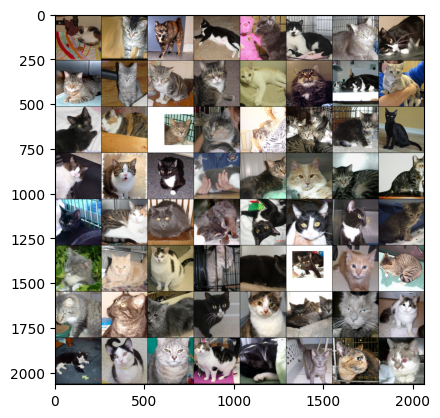

In [8]:
#get sample batch
sample_batch, labels = next(iter(cats_loader))

#make grid image
grid = torchvision.utils.make_grid(sample_batch)

#convert CHW(channels, height, width) to HWC and display
grid = grid.permute(1,2,0)
plt.imshow(grid)

## **Forward Diffusion**
Let's now implement the forward diffusion process

In [9]:
#function to get a linear noise schedule
def get_noise_schedule(start, end, timesteps):
  beta = torch.linspace(start, end, timesteps)
  alpha = 1 - beta
  alpha_bar = torch.cumprod(alpha, dim=0)
  return beta, alpha, alpha_bar

In [10]:
def get_noised_image(image, alpha_bar, t):
  image_t = image * torch.sqrt(alpha_bar[t]) + torch.sqrt((1-alpha_bar[t]))*torch.randn_like(image)
  return image_t

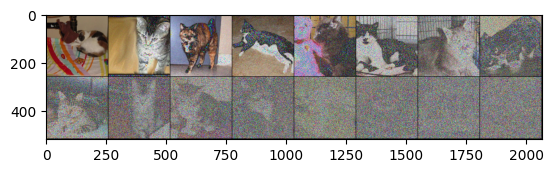

In [11]:
#test forward diffusion
sample_steps=16
beta, alpha, alpha_bar = get_noise_schedule(1e-4, 0.02, sample_steps)
img_arr = torch.empty(sample_steps,3,256,256)
for t in range(sample_steps):
  img_arr[t] = (get_noised_image(sample_batch[t], alpha_bar, t)*255).type(torch.uint8)

noised_grid = torchvision.utils.make_grid(img_arr).permute(1,2,0)
plt.imshow(noised_grid.type(torch.uint8))

## U-Net
Let's now implement the U-Net that predicts the reverse diffusion process. I've designed the U-Net as follows, taking the following into consideration:
- Experimental evidence of better performance from [Prafulla Dhariwal et al.](https://arxiv.org/abs/2105.05233) on increasing the depth of the network while decreasing the width; i.e., large number of convolutional layers with gradual increasing of the number of channels.
- Strategic placement of self-attention modules to capture both resolution and a large amount of features.
- Alternate skip connections to preserve high level semantic information while reducing computational overhead.
- Computationally efficient ReLU activation functions for quick training and inference, while still experimenting with more exotic activations for the attention modules.
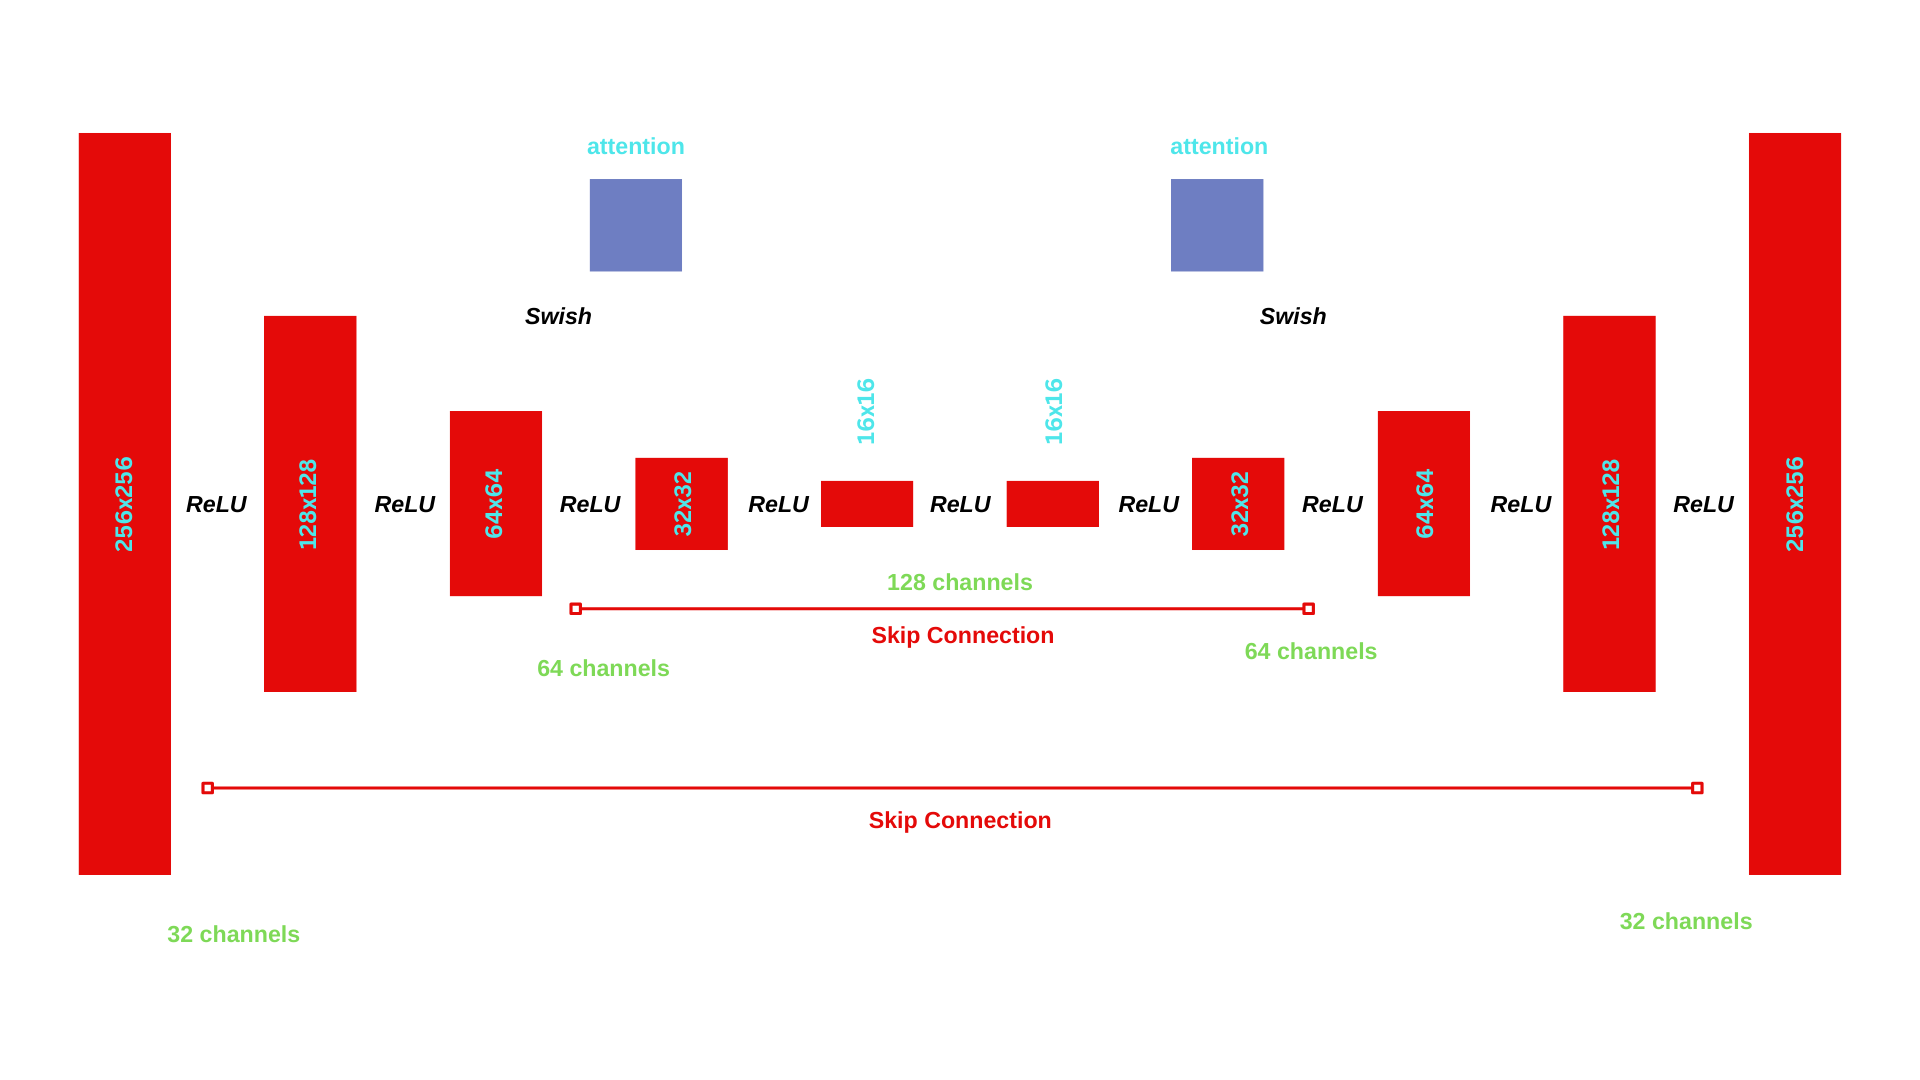

Define an enumeration for Activation functions

In [12]:
from enum import Enum
class ActivationFunction(Enum):
  RELU = 0
  SWISH = 1

Define the encoder module

In [15]:
class Encoder(nn.Module):
  def __init__(self, in_channels, out_channels, activation_function=ActivationFunction.RELU, kernel_size=3, stride=1, padding=1):
    super().__init__()
    self.activation = nn.ReLU() if activation_function == ActivationFunction.RELU else nn.SiLU()
    self.block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        self.activation,
        nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
        self.activation,
        nn.MaxPool2d(2)
    )


Define the decoder module

In [ ]:
class Decoder(nn.Module):
  def __init__(self, in_channels, out_channels, activation_function=ActivationFunction.RELU, kernel_size=2, stride=2, padding=1):
    super().__init__()
    self.activation = nn.ReLU() if activation_function == ActivationFunction.RELU else nn.SiLU()
    self.block = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
        self.activation,
        nn.ConvTranspose2d(out_channels, out_channels, kernel_size, stride, padding),
        self.activation,
        nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
        self.activation
    )